In [1]:
'''
Uses the Tensoflow machine learning library to train the Poisson 
autoencoder inverting network (PAIN) to reconstruct compressed 
MNIST images with Poisson noise, and saves the trained model.

Authors: Fabian Santiago
Last Update: August 18, 2024
'''
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.util.shape import view_as_windows

2024-08-18 22:30:58.887591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the seed for TensorFlow and Keras
tf.random.set_seed(101)

In [3]:
# Define sliding window compression
def median_downsampling(in_image, cmp_dim):
    if cmp_dim < 15:
        # Compression dimension to window size
        window_size = 28//cmp_dim
        # Create sliding windows
        windows = view_as_windows(in_image, (window_size, window_size), step=window_size)
        # Calculate the median over each window
        return np.median(windows, axis=(2, 3))
    else:
        return in_image

# Define compression of entries in an array
def down_sample_list(in_array,cmp_dim):
    out_array = np.empty((len(in_array), cmp_dim, cmp_dim))
    
    # Iterate over array
    for idx, image in enumerate(in_array):
        out_array[idx] = median_downsampling(image,cmp_dim)
        
    # Return array containing compressed entries 
    return out_array 

In [4]:
# Load the MNIST Dataset
########################
# Load only MNIST images
(clean_train, _), (clean_test, _) = tf.keras.datasets.mnist.load_data()

# Dimension of the compressed/noisy images (width=height)  
# cmp_dim = 4 (for 4x4), 7, 14, or 28
cmp_dim = 7

# Step 1: Compress images using median in sliding window
cmp_train = down_sample_list(clean_train, cmp_dim)
cmp_test  = down_sample_list(clean_test, cmp_dim)

# Step 2: Add Poisson noise to compressed images
noisy_train_ = np.random.poisson(lam=cmp_train)
noisy_test_  = np.random.poisson(lam=cmp_test)
noisy_train  = np.clip(noisy_train_,0,255)
noisy_test   = np.clip(noisy_test_,0,255)

# Step 3: Reshape Input Arrays
noisy_train = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_train/255])
noisy_test  = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_test/255])

# Step 4: Reshape Expected Ouput Arraus
clean_train = np.array([matrix.reshape(28**2,) for matrix in clean_train/255])
clean_test  = np.array([matrix.reshape(28**2,) for matrix in clean_test/255])

In [5]:
noisy_train[0].shape

(49,)

In [6]:
# Input Data Values
in_dim   = cmp_dim  # This is the input dimemsions in_dim x in_dim
in_size  = int(in_dim*in_dim)
out_dim  = 28 # never changes because MNIST original are 28 x 28
out_size = int(28*28)

In [7]:
# Define Poisson autoencoder inverting network (PAIN)
####################################################

encoder_size = 256 # Size of intermediate layer

# Define model architecture
def MODEL(input_shape):
    # Input layer
    inputs = tf.keras.Input(shape=(input_shape,))

    # First Decoder
    Dec1 = tf.keras.layers.Dense(out_size, activation='sigmoid')(inputs)

    # Encoder
    Enc2_hidden = tf.keras.layers.Dense(encoder_size, activation='sigmoid')(Dec1)
    Enc2 = tf.keras.layers.Dense(in_size, activation='sigmoid')(Enc2_hidden)

    # Second Decoder
    Dec2_hidden = tf.keras.layers.Dense(encoder_size, activation='sigmoid')(Enc2)
    outputs = tf.keras.layers.Dense(out_size, activation='sigmoid')(Dec2_hidden)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [8]:
# Create the model
PAIN = MODEL(in_size)

# Create an RMSProp optimizer with a specific learning rate
RMSp = tf.keras.optimizers.RMSprop(learning_rate=0.05)

# Compile the model
###################
PAIN.compile(optimizer=RMSp, loss='mean_squared_error')

In [9]:
PAIN.fit(noisy_train, clean_train, epochs=400, batch_size=250,validation_data=(noisy_test, clean_test))

Epoch 1/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0725 - val_loss: 0.0677
Epoch 2/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0677 - val_loss: 0.0676
Epoch 3/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0676 - val_loss: 0.0675
Epoch 4/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0673 - val_loss: 0.0625
Epoch 5/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0634 - val_loss: 0.0610
Epoch 6/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0610 - val_loss: 0.0599
Epoch 7/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0602 - val_loss: 0.0593
Epoch 8/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0596 - val_loss: 0.0572
Epoch 9/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0569 - val_loss: 0.0553
Epoch 10/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0554 - val_loss: 0.0537
Epoch 11/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0540 - val_loss: 0.0522
Epoch 12/400
240/240 ━━━━━━━━━━━━━━━━━━━━

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0255 - val_loss: 0.0259
Epoch 69/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 70/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0253 - val_loss: 0.0257
Epoch 71/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0252 - val_loss: 0.0257
Epoch 72/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0251 - val_loss: 0.0256
Epoch 73/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0250 - val_loss: 0.0255
Epoch 74/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0250 - val_loss: 0.0255
Epoch 75/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0249 - val_loss: 0.0254
Epoch 76/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0248 - val_loss: 0.0253
Epoch 77/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0247 - val_loss: 0.0252
Epoch 78/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0247 - val_loss: 0.0252
Epoch 79/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0222 - val_loss: 0.0229
Epoch 136/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0222 - val_loss: 0.0229
Epoch 137/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0222 - val_loss: 0.0227
Epoch 138/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0222 - val_loss: 0.0229
Epoch 139/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0222 - val_loss: 0.0227
Epoch 140/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0221 - val_loss: 0.0228
Epoch 141/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 142/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 143/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0221 - val_loss: 0.0225
Epoch 144/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0220 - val_loss: 0.0227
Epoch 145/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0220 - val_loss: 0.0227
Epoch 146/400
240/240

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0209 - val_loss: 0.0219
Epoch 202/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0209 - val_loss: 0.0220
Epoch 203/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0209 - val_loss: 0.0219
Epoch 204/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0209 - val_loss: 0.0217
Epoch 205/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0209 - val_loss: 0.0218
Epoch 206/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0209 - val_loss: 0.0218
Epoch 207/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0209 - val_loss: 0.0219
Epoch 208/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0208 - val_loss: 0.0218
Epoch 209/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0208 - val_loss: 0.0219
Epoch 210/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0208 - val_loss: 0.0218
Epoch 211/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0208 - val_loss: 0.0219
Epoch 212/400
240/240 ━━━━━━━━━━━━━

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0201 - val_loss: 0.0214
Epoch 268/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0201 - val_loss: 0.0215
Epoch 269/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 270/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 271/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0201 - val_loss: 0.0215
Epoch 272/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0200 - val_loss: 0.0215
Epoch 273/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0213
Epoch 274/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0215
Epoch 275/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0215
Epoch 276/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 277/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0215
Epoch 278/400
240/240 ━━━━━━━━━━━━━

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0194 - val_loss: 0.0213
Epoch 334/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0212
Epoch 335/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0210
Epoch 336/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 337/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0213
Epoch 338/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0194 - val_loss: 0.0213
Epoch 339/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 340/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0194 - val_loss: 0.0212
Epoch 341/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 342/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0213
Epoch 343/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0212
Epoch 344/400
240/240 ━━━━━━━━━━━━━

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0189 - val_loss: 0.0211
Epoch 400/400
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0189 - val_loss: 0.0212


In [10]:
# Save Trained Model
####################

# Model directory 
directory = "Trained_Models"

# If directory does not exist, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Save trained model
PAIN.save(f'Trained_Models/PAIN{cmp_dim}x{cmp_dim}.keras')

In [11]:
# Apply PAIN to all training inputs
pred_train_out = PAIN.predict(noisy_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


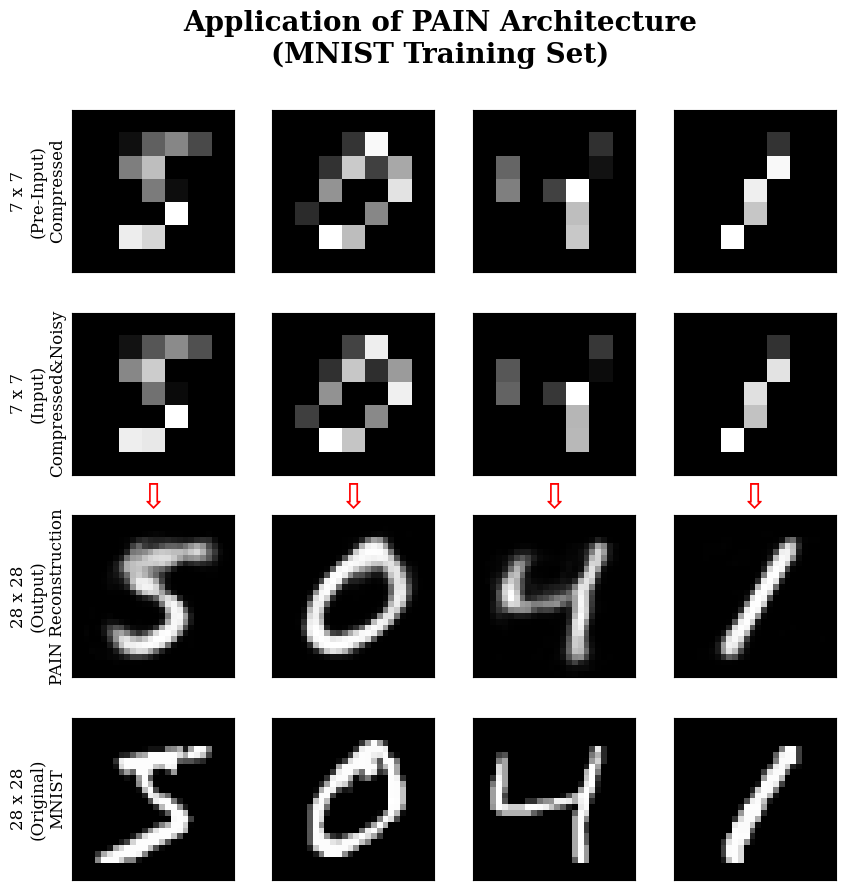

In [15]:
# Print examples: training set
########################################################

# Create a 4 by 4 subplot handle
fig, axes = plt.subplots(4, 4, figsize=(11, 10))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of PAIN Architecture\n(MNIST Training Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift through training dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot ompressed images
    axes[idx].imshow(cmp_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    
    # Plot noisy
    axes[idx+4].imshow(noisy_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    axes[idx+4].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'red'})
    # Plot decompressed with PAIN
    axes[idx+8].imshow(pred_train_out[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+12].imshow(clean_train[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+12].set_xticks([]) # Remove xticklabels
    axes[idx+12].set_yticks([]) # Remove yticklabels
    
# Set ylables 
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Pre-Input)\nCompressed',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[4].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed&Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[8].set_ylabel('28 x 28\n(Output)\nPAIN Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[12].set_ylabel('28 x 28\n(Original)\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=-0.2, hspace=0.25)

# Display the figure
plt.show()
    

In [13]:
# Apply PAIN to all validation inputs
pred_test_out = PAIN.predict(noisy_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


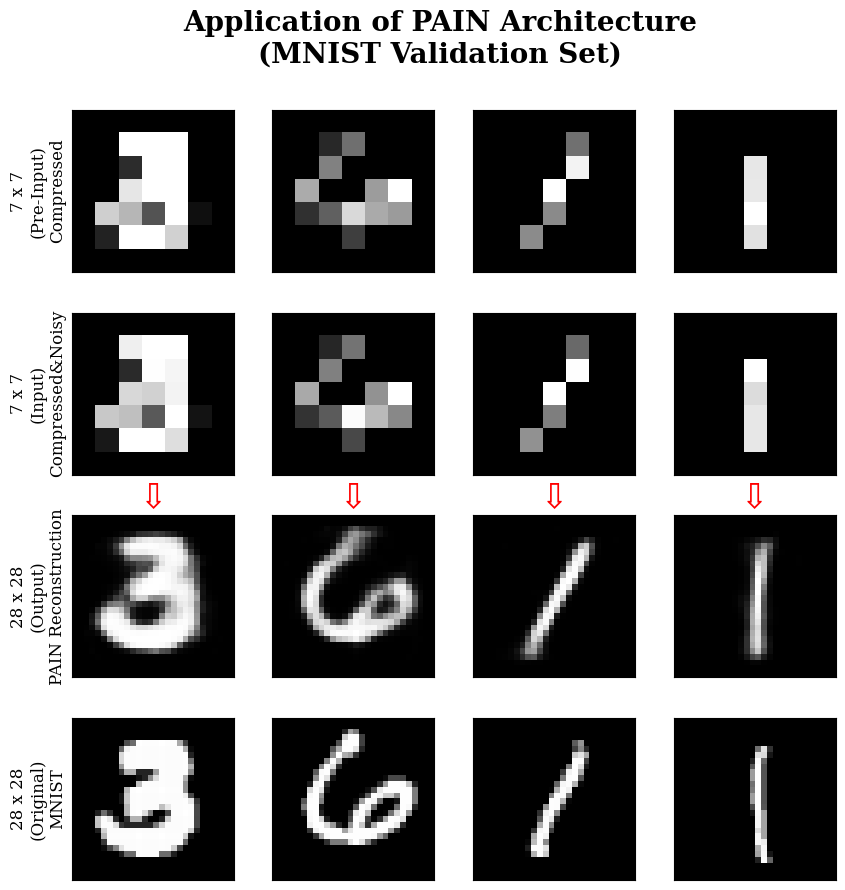

In [16]:
# Print examples: validation set
########################################################

# Create a 4 by 4 subplot handle
fig, axes = plt.subplots(4, 4, figsize=(11, 10))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of PAIN Architecture\n(MNIST Validation Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift through validation dataset 
sft_idx = 200

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot ompressed images
    axes[idx].imshow(cmp_test[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    
    # Plot noisy
    axes[idx+4].imshow(noisy_test[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    axes[idx+4].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'red'})
    # Plot decompressed with PAIN
    axes[idx+8].imshow(pred_test_out[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+12].imshow(clean_test[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+12].set_xticks([]) # Remove xticklabels
    axes[idx+12].set_yticks([]) # Remove yticklabels
    
# Set ylables 
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Pre-Input)\nCompressed',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[4].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed&Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[8].set_ylabel('28 x 28\n(Output)\nPAIN Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[12].set_ylabel('28 x 28\n(Original)\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=-0.2, hspace=0.25)

# Display the figure
plt.show()